- **Which datasets do you anticipate using in your final project? Are there columns that can be used to merge these datasets into a single dataframe?**

The datasets we plan to use in our final project are the section 12 alcohol licenses dataset and crime incidents data report from boston.gov. As well as the BARI census block groups mapping from Harvard dataverse and potentially the 911 calls ecometrics. The columns that can be used to merge these datasets are based on location. The crime and alcohol datasets include the address and street name of the business or incident. They also include latitude and longitude coordinates which are likely going to be most effective to use to find their position on the map. Since the geographic data reported by the Boston police can be slightly off we can't rely too heavily on it's accuracy, therefore when merging the data together with a spatial join it's important to note that these areas of city blocks represent overall crime in this area, but not at any exact address or coordinate. Other shared columns are the dates. The licenses and crime incidents both include the date of issue or occurrence which represents another possible area to merge the data although this is not our main focus for now.


- **What is the unit(s) of analysis you will be studying for your final project? In other words, what is the unit that each row in your final dataframe(s) will represent? Is this the same level of analysis that is represented in your raw data? If not, what columns in your raw data could be used to aggregate it to the level you need for your study?**

The unit of analysis for our project are city issued alcohol licenses in Boston, MA and incidents of alcohol related crimes. This is because we are looking to see if a neighborhood block group with a higher number of alcohol licenses is more prone to alcohol related crimes (Operating Under the Influence, Liquor Violation, and potentially violence related crimes based on peer reviewed research) than neighborhood block groups with fewer total licenses. In the final dataframe we would have latitude and longitude cordinates of these specific filtered crimes which are mapped onto specific city block groups in the greater Boston area. The level of analysis is not the same as represented in the raw data since our raw data includes the licenses and incidents on an individual basis. As stated above, we will need to do some type of aggregation (most likely spatial join) of crimes and licenses based on location from the raw data, in order to evaluate our research question.

### Load in and compile two datasets to find missing items for final question

In [542]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [543]:
crime_2015 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2016 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2017 = pd.read_csv('data/crime-incident-reports-2017.csv')
crime_2018 = pd.read_csv('data/crime-incident-reports-2018.csv')

In [544]:
crime = pd.DataFrame()
crime=crime.append(crime_2015, ignore_index=True)
crime=crime.append(crime_2016, ignore_index=True)
crime=crime.append(crime_2017, ignore_index=True)
crime=crime.append(crime_2018, ignore_index=True)
crime=crime[['OFFENSE_CODE', 'OFFENSE_DESCRIPTION', 'YEAR', 'Lat', 'Long']]

In [545]:
alc = pd.read_csv('data/blb_section_12_alcohol.csv')
alc=alc[['license_num', 'issued', 'license_type', 'status', 'dba_name', 'gpsx', 'gpsy']]

In [546]:
colleges = pd.read_csv('data/Colleges_and_Universities.csv')
colleges = colleges[['Name', 'Latitude', 'Longitude']]

In [547]:
off_codes = [2201, 2101, 2646]
crime = crime.loc[crime['OFFENSE_CODE'].isin(off_codes)]
crime = crime[crime[['Lat', 'Long']].notnull().all(1)]

In [548]:
alc = alc.loc[alc['license_type'].str.contains('All Alc.')]

In [549]:
nb = gpd.read_file("data/Boston_Neighborhoods.geojson")
nb = nb.astype({'Neighborhood_ID': 'int64'})
# nb

In [550]:
crime_gdf = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime.Long, crime.Lat))
crime_gdf = crime_gdf.set_crs("EPSG:4326")
crime_gdf = gpd.sjoin(crime_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
crime = pd.DataFrame(crime_gdf.drop(columns=['geometry', 'index_right']))
crime
# crime.dropna(subset = ['Neighborhood_ID'])
crime = crime[crime['Neighborhood_ID'].notna()]
crime = crime.astype({'Neighborhood_ID': 'int64'})
# crime

In [551]:
college_gdf = gpd.GeoDataFrame(colleges, geometry=gpd.points_from_xy(colleges.Longitude, colleges.Latitude))
college_gdf = college_gdf.set_crs("EPSG:4326")
college_gdf = gpd.sjoin(college_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
colleges = pd.DataFrame(college_gdf.drop(columns=['geometry', 'index_right']))
colleges = colleges[colleges[['Neighborhood_ID']].notnull().all(1)]
colleges = colleges.astype({'Neighborhood_ID': 'int64'})
colleges = colleges[colleges.Neighborhood_ID != 28]

In [552]:
alc_latlong = pd.read_csv('data/alc_coords.csv')
alc_latlong = alc_latlong.rename(columns={"ID":"license_num"})
alc_latlong
alc = pd.merge(alc, alc_latlong, on="license_num")
alc=alc[['license_type', 'license_num', 'status', 'dba_name', 'srcLat', 'srcLon']]
alc = alc[alc[['srcLat', 'srcLon']].notnull().all(1)]
alc = alc.loc[alc['srcLat'] > 35.0]

In [553]:
alc_gdf =gpd.GeoDataFrame(alc, geometry=gpd.points_from_xy(alc.srcLon, alc.srcLat))
alc_gdf = alc_gdf.set_crs("EPSG:4326")
alc_gdf = gpd.sjoin(alc_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
alc = pd.DataFrame(alc_gdf.drop(columns=['geometry', 'index_right']))
alc = alc[alc[['Neighborhood_ID']].notnull().all(1)]
alc = alc.astype({'Neighborhood_ID': 'int64'})

In [554]:
# crime.Neighborhood_ID.unique()

In [555]:
# crime.loc[crime['Neighborhood_ID'] == 28]

In [556]:
# colleges

In [557]:
bar_count = alc.groupby(by=['Neighborhood_ID']).count()['license_num']
bar_count = bar_count.rename('bar_count')
# bar_count

Note: crime_count is not counting offenses from outside of Boston

In [558]:
crime_count = crime.groupby(by=['Neighborhood_ID']).count()['OFFENSE_CODE']
crime_count = crime_count.rename('crime_count')
# crime_count

In [559]:
cols = {'crime':crime_count}
crime_df = pd.DataFrame(cols)

cols1 = {'bars':bar_count}
bars_df = pd.DataFrame(cols1)
bars_df = bars_df.drop(28)
# bars_df

In [560]:
combined_df = crime_df.join(bars_df, how='inner', sort=False)
combined_df

,crime,bars
Neighborhood_ID,,
2,64,95
4,9,18
6,182,70
7,50,155
8,62,35
10,18,10
11,35,19
12,76,8
13,49,8


In [561]:
college_geo = gpd.points_from_xy(colleges.Longitude, colleges.Latitude)
c_geo_df = gpd.GeoDataFrame(geometry = college_geo)

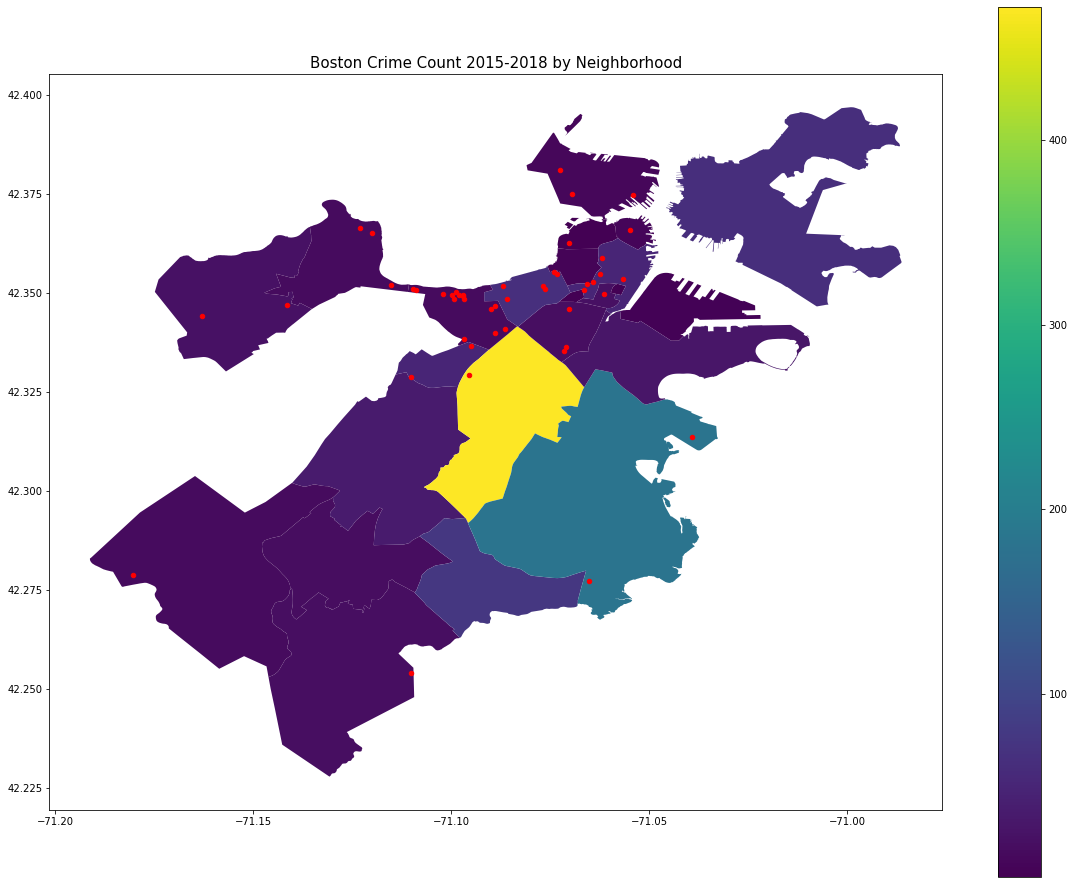

In [562]:
fig,ax = plt.subplots(figsize = (20,16))
crime_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
crime_map.plot(ax = ax, column = 'crime', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 20, color = 'red')
plt.title('Boston Crime Count 2015-2018 by Neighborhood', fontsize = 15)
plt.show()

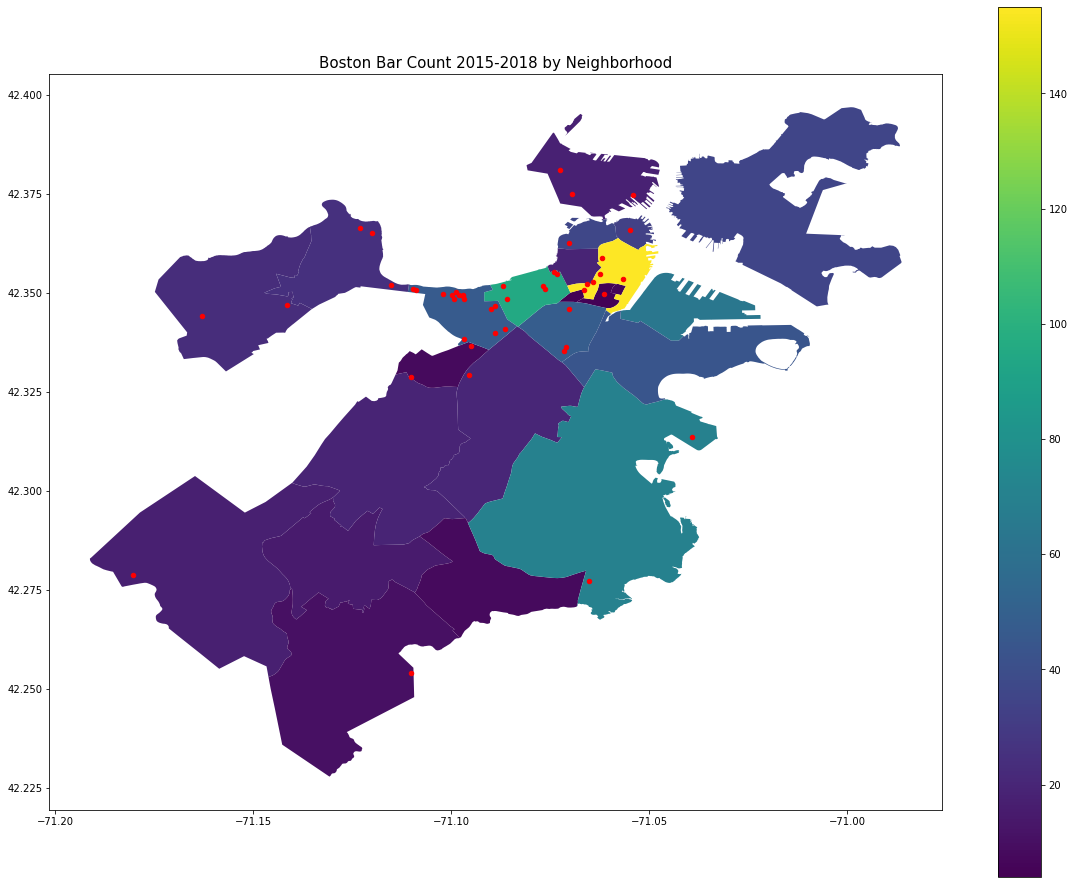

In [563]:
fig,ax = plt.subplots(figsize = (20,16))
bar_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
bar_map.plot(ax=ax, column = 'bars', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 20, color = 'red')
plt.title('Boston Bar Count 2015-2018 by Neighborhood', fontsize = 15)
plt.show()

print("Percentage of missing 'Lat' data in crime dataset:")
print(sum(df_crime.Lat.isna()) / len(df_crime)*100,'%')

print("Percentage of missing 'Long' data in crime dataset:")
print(sum(df_crime.Long.isna()) / len(df_crime)*100, '%')

print("Percentage of missing 'OFFENSE_CODE_GROUP' data in crime dataset:")
print(sum(df_crime.OFFENSE_CODE_GROUP.isna()) / len(df_crime)*100, '%')

print("Percentage of missing 'OFFENSE_CODE' data in crime dataset:")
print(sum(df_crime.OFFENSE_CODE.isna()) / len(df_crime)*100, '%')

print("Percentage of missing 'OCCURRED_ON_DATE' data in crime dataset:")
print(sum(df_crime.OCCURRED_ON_DATE.isna()) / len(df_crime)*100, '%')

print('-' * 50)

print("Percentage of missing 'gpsx' data in liquor license dataset:")
print(sum(df_alc.gpsx.isna()) / len(df_crime)*100, '%')

print("Percentage of missing 'gpsy' data in liquor license dataset:")
print(sum(df_alc.gpsy.isna()) / len(df_crime)*100, '%')

print("Percentage of missing 'ISSUED' data in liquor license dataset:")
print(sum(df_alc.issued.isna()) / len(df_crime)*100, '%')

print("Percentage of missing 'license_type' data in liquor license dataset:")
print(sum(df_alc.license_type.isna()) / len(df_crime)*100, '%')

- **If you have the data for your project in hand: Evaluate your main columns of interest for missing data. What percentage of rows are missing data? Can you see any patterns in which rows are missing data?**

The main columns of interest chosen in the evaluation above are the location data of both the licenses and crime incidents and various other important factors. The location data for both is split up into latitude and longitude coordinates where some rows have both values NA. In the crime dataset 3.97% of rows contain missing location data and in the licenses dataset 0.09% contained missing location data. Given the crime dataset contains nearly 35x more rows than the licenses, with ~4% of crimes missing a location we are still left with a large number of crime incidents (51,000+) with a location. The other important features for crime including the offense code and occurence date contain no NA values. The issued date column for the licenses contained 0.013% NA values which, similar to the location, is a very small portion of the data. The licenses type column contained 0% NA values.

A general pattern observed in the missing data is that latitude and longitude columns are missing the same data, which is helpful because it means that either the entire location was recorded or not at all. If it was not recorded we can exclude this point. Another note is that in the future we will need additional techniques beyond just checking NA for the location. We could also check if the location is outside of Boston, since we only want to include crimes in this area, and there could be rows with errors in the latitude and longitude that we don't want included in our analysis, but aren't NA.